In [1]:
# to input data 
import numpy as np
import pandas as pd

# to visualize data
import matplotlib.pyplot as plt

# to prepare data
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans

from catboost import CatBoostClassifier

## 1. Input Data & Data Analysis

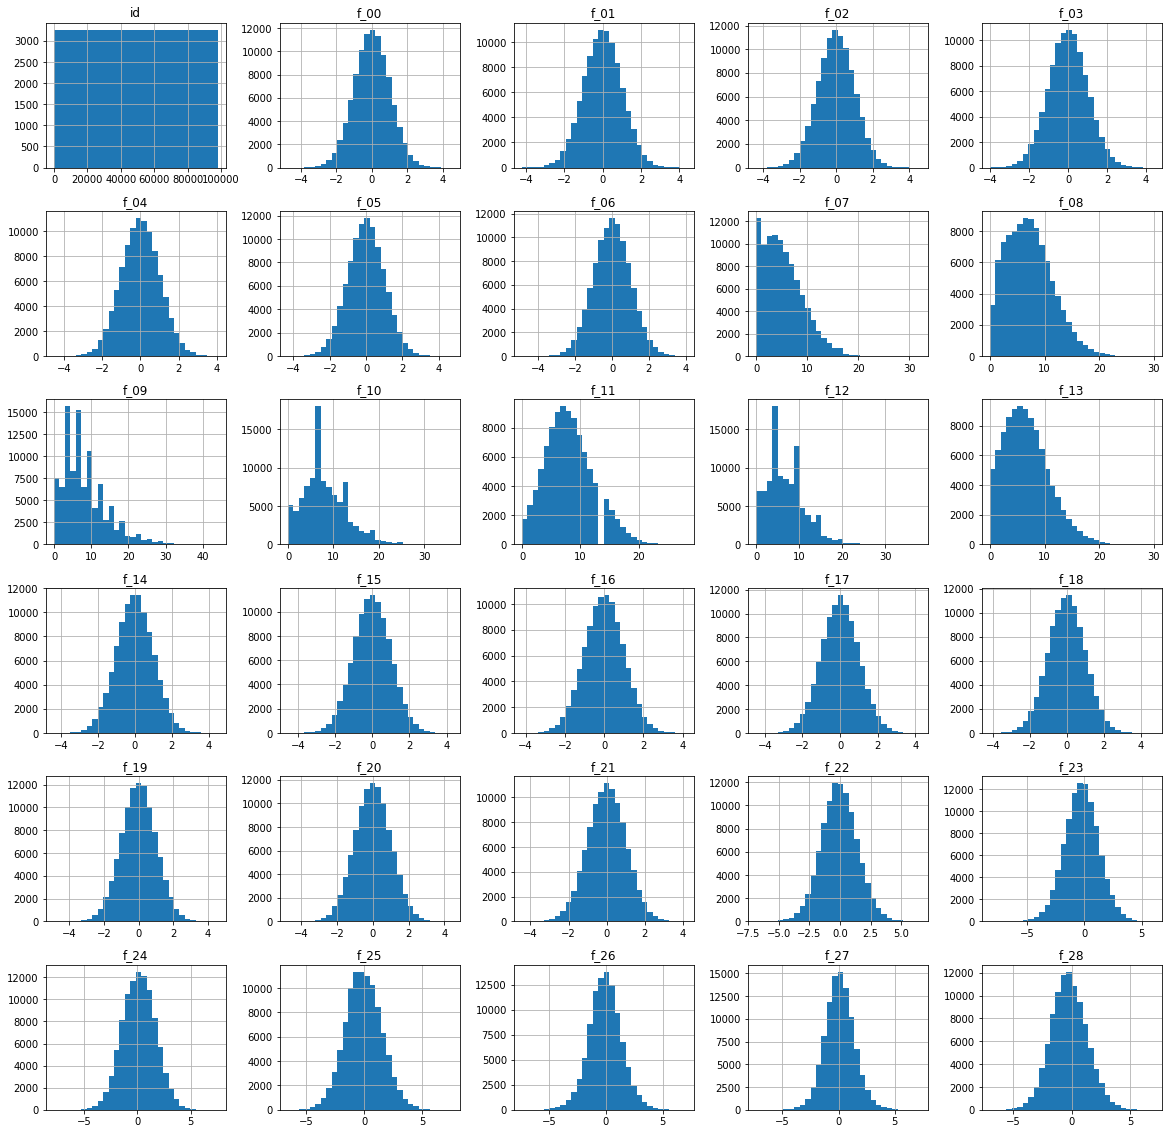

In [2]:
train=pd.read_csv("data/data.csv")

train.hist(figsize=(20, 20), bins=30);

As we can see a lot of graphs have a very similar distribution (f_00 and f_05 for example) therefore, we need to drop unwanted data and leave these columns: f_07, f_08, f_09, f_10, f_11, f_12, f_13, 'f_22', f_23, f_25, 'f_26', 'f_27' and 'f_28'. These data have different distributions and that's very important for training our model.

In [3]:
cols_all = train.columns
cols_best =['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13', 'f_22', 'f_23', 'f_24', 'f_25', 'f_26', 'f_27', 'f_28']
cols_drop=[col for col in cols_all if col not in cols_best]

train=train.drop(cols_drop, axis=1)

## 2. Data Preprocessing

Let's check for data types to determine the outliers of numerical data.

In [4]:
train.dtypes

f_07      int64
f_08      int64
f_09      int64
f_10      int64
f_11      int64
f_12      int64
f_13      int64
f_22    float64
f_23    float64
f_24    float64
f_25    float64
f_26    float64
f_27    float64
f_28    float64
dtype: object

Obviously, 'f_23', 'f_24', and 'f_27' are numerical features so we need to cut outliers by means of RobustScaler.

In [5]:
# categorical data
cols_int = ['f_07','f_08', 'f_09', 'f_10','f_11', 'f_12', 'f_13']
# numerical data
cols_float = [col for col in cols_best if col not in cols_int]

# IQR
def iqr_outliers(df, col_list):
    for col in col_list:
        transformer = RobustScaler()
        df[col] = transformer.fit_transform(df[col].to_numpy().reshape(-1, 1))
    return df

train = iqr_outliers(train, cols_float)

And now we need to scale data and transform our data. And since this data do have negative values, I will use Yeo-Johnson method. These transformations are necessery for normal training of a model otherwise we will waste too much memory during training.

In [6]:
# copy train data
train_scaled=train.copy()
# to make data more Gaussian-like
train_scaled[cols_best]= PowerTransformer(method='yeo-johnson', standardize=True).fit_transform(train_scaled[cols_best])
# scale data
train_scaled[cols_best]= MinMaxScaler().fit_transform(train_scaled[cols_best])

In [7]:
print("Before Transformation:")
display(train.head(2))
print("After Transformation:")
display(train_scaled.head(2))

Before Transformation:


,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,2,13,14,5,13,6,6,-0.529246,0.691952,-0.495728,0.584470,0.758663,0.825922,0.533586
1,2,3,6,4,6,16,9,-0.400787,0.344902,0.750813,-0.083245,-0.429556,0.287253,-1.184987


After Transformation:


,f_07,f_08,f_09,f_10,f_11,f_12,f_13,f_22,f_23,f_24,f_25,f_26,f_27,f_28
0,0.175151,0.588714,0.586435,0.288538,0.576299,0.349190,0.366363,0.446971,0.653336,0.458056,0.571387,0.608211,0.630081,0.588454
1,0.175151,0.208920,0.370471,0.246313,0.321894,0.628359,0.479532,0.465921,0.605345,0.630185,0.472091,0.458150,0.569720,0.333024


## 3. Build and Train Model

Let's find optimal number of cluster of our data to set the hyperparameter in BayesianGaussianMixture. To do this, we will use Elbow Method.

In [8]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(train)
    Sum_of_squared_distances.append(km.inertia_)

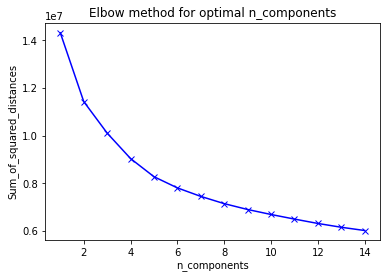

In [9]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('n_components')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow method for optimal n_components')
plt.show()

As can be seen on the graph, our value equals between 6 and 8. Consequently, we will choose 7.

In [10]:
BGM = BayesianGaussianMixture(n_components=7, covariance_type='full', random_state=1)
BGM.fit(train_scaled[cols_best])

predict=BGM.predict(train_scaled[cols_best])
proba=BGM.predict_proba(train_scaled[cols_best])

train_scaled['predict']=predict
train_scaled['predict_proba']=np.max(proba, axis=1) 

train_index=train_scaled[train_scaled.predict_proba > 0.7].index
print(round(len(train_index)/len(train),3))

0.742


Now we found ~75% of predict labels for our data. We will find remaining 25% means by CatBoostClassifier. This is good library for gradient boosting on decision trees that fits well in our case.

In [11]:
X=train_scaled.loc[train_index][cols_best]
y=train_scaled.loc[train_index]['predict']

model = CatBoostClassifier(iterations=1000,
                           depth=7,
                           learning_rate=0.07,
                           loss_function='MultiClassOneVsAll',
                           verbose=True)

model.fit(X,y)

In [12]:
ss=pd.read_csv("data/sample_submission.csv")
ss['Predicted'] = model.predict(train_scaled[cols_best])

ss.to_csv("submission.csv",index=False)
ss.head()

,Id,Predicted
0,0,4
1,1,6
2,2,4
3,3,3
4,4,1


## Score: 0.61536